# Tutorial 4: Protein DMS modeling using a biophysical G-P map

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Special imports
import mavenn

Here we show how to train and visualize a thermodynamic model  describing the folding and IgG-binding of protein GB1 variants. This model was first proposed by Otwinowski (2018), who trained it on the DMS data of Olson et al. (2014). Here we repeat this exercise within the MAVE-NN framework, thus obtaining a model similar to the one featured in Figs. 6a and 6b of Tareen et al. (2021). The mathematical form of this G-P map is explianed in the supplemental material of Tareen et al. (2021); see in particular  Fig. S4a.

## Defining a custom G-P map

First we define a custom G-P map that represents our biophysical model. We do this by subclassing `CustomGPMapLayer` to get a custom G-P map class called `OtwinowskiGPMapLayer`. This subclassing procedure requires that we fill in the bodies of four specific methods.
- `__init__()`: The constructor must take as input and then record at least three specific parameters: `L` (sequence length), `C` (alphabet size), and `theta_regularization` (the strength of G-P map parameter regularization). The constructor must also end by calling `super().__init__(*args, **kwargs)`, which passes all additional arguments to the superclass constructor.
- `build()`: This method defines the trainable parameters (i.e., the weights) of the custom G-P map: these are named `theta_f_0`, `theta_b_0`, `theta_f_lc`, and `theta_b_lc`.  TensorFlow provides this method with an argument called `input_shape`, and the superclass method `super().build(input_shape)` must be called before exiting.
- `call()`: This is the meat of the custom G-P map. The input `x_lc` is a one-hot encoding of all sequences in a minimatch. It has size `[-1, L, C]`, where the first index runs over minibatch examples. The G-P map parameters are then used to compute and return a vector `phi` of latent phenotype values, one for each input sequence in the minibatch.
- `get_parameters()`: This method returns a `dict` object that lists the values of model parameters. Note that these values must be `float` or `np.ndarray` objects, not TensorFlow tensor objects.
- `set_parameters()`: This method takes a `dict` of the form returned by `get_parameters()` and sets the values of the the `OtwinowskiGPMapLayer` weights.

In [2]:
# Standard TensorFlow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

# Import base class
from mavenn.src.layers.gpmap import CustomGPMapLayer

# Define custom G-P map layer
class OtwinowskiGPMapLayer(CustomGPMapLayer):
    """
    A G-P map representing the thermodynamic model described by
    Otwinowski (2018).
    """

    def __init__(self, L, C, theta_regularization, *args, **kwargs):
        """
        Construct layer instance.
        """
        
        # Set sequence length and alphabet size
        self.L = L
        self.C = C

        # Define L2 regularizer of G-P map parameters
        self.regularizer = tf.keras.regularizers.L2(theta_regularization)

        # Call superclass constructor
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Define layer parameters."""
        
        # Initialize constant parameter for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize constant parameter for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize additive parameter for folding energy
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # Initialize additive parameter for binding energy
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Compute phi given x."""

        # Thermal energy scale (k_B * T) in units of kcal/mol
        kT = 0.62

        # Reshape input to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # Compute Delta G for binding
        Delta_G_b = self.theta_b_0 + \
                    tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
            
        # Compute Delta G for folding
        Delta_G_f = self.theta_f_0 + \
                    tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
        
        # Compute and return fraction folded and bound
        Z = 1+K.exp(-Delta_G_f/kT)+K.exp(-(Delta_G_f+Delta_G_b)/kT)
        p_bf = (K.exp(-(Delta_G_f+Delta_G_b)/kT))/Z
        phi = p_bf #K.log(p_bf)/np.log(2)
        return phi

    def get_params(self):
        """
        Get values of layer parameters.
        Note: all energy parameter values are in units of kcal/mol
        """

        param_dict = {}
        param_dict['theta_b_0'] = np.float(self.theta_b_0)
        param_dict['theta_f_0'] = np.float(self.theta_f_0)
        param_dict['theta_b_lc'] = np.squeeze(self.theta_b_lc)
        param_dict['theta_f_lc'] = np.squeeze(self.theta_f_lc)
        return param_dict

    def set_params(self, param_dict):
        """Set values of layer parameters."""

        #TODO: Fill out set_params function ->Mahdi


## Training a model with a custom G-P map

Next we load the `'gb1'` dataset, compute sequence length, and split the data into a test set and a training+validation set.

In [3]:
# Choose dataset
data_name = 'gb1'
print(f"Loading dataset '{data_name}' ")

# Load datset
data_df = mavenn.load_example_dataset(data_name)

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} amino acids')

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Preview trainval_df
print('trainval_df:')
trainval_df

Loading dataset 'gb1' 
Sequence length: 55 amino acids
Training set   :  477,854 observations (  90.04%)
Validation set :   26,519 observations (   5.00%)
Test set       :   26,364 observations (   4.97%)
-------------------------------------------------
Total dataset  :  530,737 observations ( 100.00%)

trainval_df:


,validation,dist,input_ct,selected_ct,y,x
0,False,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,False,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,False,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,False,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,False,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
...,...,...,...,...,...,...
504368,False,2,462,139,-2.515259,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
504369,False,2,317,84,-2.693165,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
504370,False,2,335,77,-2.896589,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
504371,False,2,148,28,-3.150861,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


Next we create an instance of the `mavenn.Model` class. In addition to standard keyword arguments for GE regression, we pass keyword arguments specific to the use of our custom G-P map:

- `gpmap_type='custom'`: Alerts the `mavenn.Model()` constructor that we wish to use a custom G-P map.
- `custom_gpmap=OtwinowskiGPMapLayer`: Specifies the specific class to use for the custom G-P map layer.
- `gpmap_kwargs=gpmap_kwargs`: Provides a dictionary of arguments to be passed to the constructor of the custom G-P map.

In [4]:
# Order the alphabet to match Otwinowski (2018)
alphabet = np.array(list('KRHEDNQTSCGAVLIMPYFW'))
C = len(alphabet)

# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':C,
                'theta_regularization': 0.0005}

# Create model instance
model = mavenn.Model(L=L,
                     alphabet=alphabet,
                     regression_type='GE',
                     ge_nonlinearity_type='nonlinear',
                     ge_nonlinearity_monotonic=False,
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2,
                     ge_nonlinearity_hidden_nodes=100,
                     eta_regularization=0.0001,
                     gpmap_type='custom',
                     normalize_phi=False,
                     custom_gpmap=OtwinowskiGPMapLayer,
                     gpmap_kwargs=gpmap_kwargs)

As in previous tutorials, we then set the training data using `model.set_data()` and then train the model using `model.fit()`.

In [5]:
# Set False->True to train model
if False:

    # Set training data
    model.set_data(x=trainval_df['x'],
                   y=trainval_df['y'],
                   validation_flags=trainval_df['validation'])

    # Train model
    model.fit(learning_rate=.0005,
              epochs=1000,
              batch_size=300,
              early_stopping=True,
              early_stopping_patience=25,
              linear_initialization=False,
              verbose=False);

    # Save model to file
    model_name = f'{data_name}_thermodynamic_model'
    model.save(model_name)

Next we evaluate the performance of the model on test data and save the model to disk.

## Visualizing models with custom G-P maps

One can load the custom G-P map model and analyze its training history / performance in the same way as with built-in G-P map, e.g.:

In [6]:

# Load model from file
model_name = f'{data_name}_thermodynamic_model'
model = mavenn.load(model_name)

# Compute variational information on test data
I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

Model loaded from these files:
	gb1_thermodynamic_model.pickle
	gb1_thermodynamic_model.h5
test_I_var: 2.318 +- 0.014 bits
test_I_pred: 2.366 +- 0.011 bits


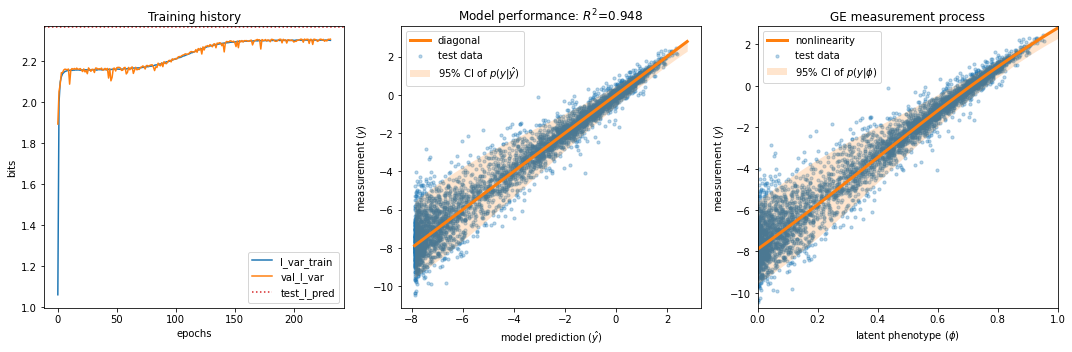

In [7]:
# Get quantities to plot
y_test = test_df['y']
N_test = len(y_test)
yhat_test = model.x_to_yhat(test_df['x'])
phi_test = model.x_to_phi(test_df['x'])
phi_lim = [0, 1]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)
ix = np.random.choice(a=N_test, size=5000, replace=False)
Rsq = np.corrcoef(yhat_test.ravel(), test_df['y'])[0, 1]**2

# Create figure and axes for plotting
fig, axs = plt.subplots(1,3,figsize=[15,5])

# Plot panel 1: Training history
ax = axs[0]
ax.plot(model.history['I_var'],
        label=r'I_var_train')
ax.plot(model.history['val_I_var'],
        label=r'val_I_var')
ax.axhline(I_pred, color='C3', linestyle=':',
           label=r'test_I_pred')
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history')
ax.legend()

## Panel 2: R^2 model performance
ax = axs[1]
ax.scatter(yhat_test[ix], y_test[ix], color='C0', s=10, alpha=.3,
           label='test data')
#xlim = [min(yhat_test), max(yhat_test)]
#ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.fill_between(yhat_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                alpha=0.2, color='C1', lw=0, label='95% CI of $p(y|\hat{y})$')
ax.plot(yhat_grid, yhat_grid,
        linewidth=3, color='C1', label='diagonal')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Model performance: $R^2$={Rsq:.3}');
ax.legend()

## Panel 3: GE plot
ax = axs[2]
ax.scatter(phi_test[ix], y_test[ix],
           color='C0', s=10, alpha=.3, label='test data')
ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                alpha=0.2, color='C1', lw=0, label='95% CI of $p(y|\phi)$')
ax.plot(phi_grid, yhat_grid,
        linewidth=3, color='C1', label='nonlinearity')
ax.set_ylim([min(y_test), max(y_test)])
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GE measurement process')
ax.legend()
fig.tight_layout()

To retrieve the parameters of our custom G-P map, we again use the method `model.get_theta()`. This returns the dictionary provided by our custom G-P map via the method `get_params()`:

In [8]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.layer_gpmap.get_params()
theta_dict.keys()

dict_keys(['theta_b_0', 'theta_f_0', 'theta_b_lc', 'theta_f_lc'])

Next we visualize the additive parameters that determine both folding energy(`theta_b_lc`) and binding energy (`theta_r_lc`). Note that we visualize these as parameters as changes (`ddG_f` and `ddG_b`) with respect to the wild-type sequence. It is also worth comparing these $\Delta \Delta G$ values to those inferred by Otwinowski (2019).


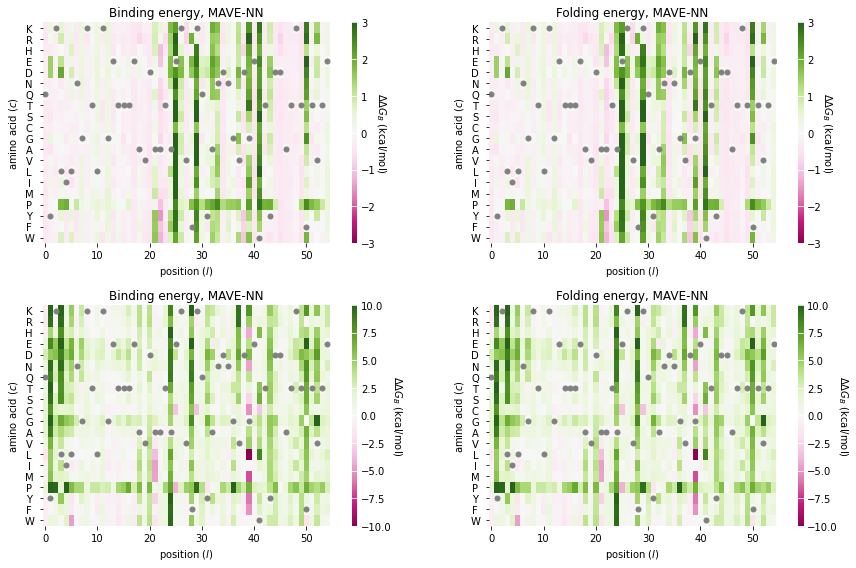

In [9]:
# Get the wild-type GB1 sequence
wt_seq = model.x_stats['consensus_seq']

# Convert this to a one-hot encoded matrix of size LxC
from mavenn.src.utils import _x_to_mat
x_lc_wt = _x_to_mat(wt_seq, model.alphabet)

# Subtract wild-type character value from parameters at each position
ddG_b_mat_mavenn = theta_dict['theta_b_lc'] - np.sum(x_lc_wt*theta_dict['theta_b_lc'], axis=1)[:,np.newaxis]
ddG_f_mat_mavenn = theta_dict['theta_f_lc'] - np.sum(x_lc_wt*theta_dict['theta_f_lc'], axis=1)[:,np.newaxis]

# Load Otwinowski parameters form file
dG_b_otwinowski_df = pd.read_csv('../../mavenn/examples/datasets/raw/otwinowski_gb_data.csv.gz', index_col=[0]).T.reset_index(drop=True)[model.alphabet]
dG_f_otwinowski_df = pd.read_csv('../../mavenn/examples/datasets/raw/otwinowski_gf_data.csv.gz', index_col=[0]).T.reset_index(drop=True)[model.alphabet]

# Compute ddG matrices for Otwinowski
ddG_b_mat_otwinowski = dG_b_otwinowski_df.values - \
                       np.sum(x_lc_wt*dG_b_otwinowski_df.values, axis=1)[:,np.newaxis]
ddG_f_mat_otwinowski = dG_f_otwinowski_df.values - \
                       np.sum(x_lc_wt*dG_f_otwinowski_df.values, axis=1)[:,np.newaxis]

# Set shared keyword arguments for heatmap
heatmap_kwargs = {
    'alphabet':model.alphabet,
    'seq':wt_seq,
    'seq_kwargs':{'c':'gray', 's':25},
    'cmap':'PiYG',
    'cbar':True,
    'cmap_size':'2%',
    'cmap_pad':.3,
    'ccenter':0
}

# Set plotting routine
def draw(ax, ddG_mat, title, clim):
        # Draw binding energy heatmap
        heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                        values=ddG_mat,
                                        clim=clim,
                                        **heatmap_kwargs)
        heatmap_ax.tick_params(axis='y', which='major', pad=10)
        heatmap_ax.set_xlabel('position ($l$)')
        heatmap_ax.set_ylabel('amino acid ($c$)')
        heatmap_ax.set_title(title)
        cb.outline.set_visible(False)
        cb.ax.tick_params(direction='in', size=20, color='white')
        cb.set_label('$\Delta \Delta G_B$ (kcal/mol)',
                     labelpad=5, rotation=-90, ha='center', va='center')

# Create figure and make plots
fig, axs = plt.subplots(2,2, figsize=(12,8))
draw(ax=axs[0,0],
     ddG_mat=ddG_b_mat_mavenn,
     title='Binding energy, MAVE-NN',
     clim=(-3, 3))
draw(ax=axs[0,1],
     ddG_mat=ddG_b_mat_mavenn,
     title='Folding energy, MAVE-NN',
     clim=(-3, 3))
draw(ax=axs[1,0],
     ddG_mat=ddG_f_mat_otwinowski,
     title='Binding energy, MAVE-NN',
     clim=(-10, 10))
draw(ax=axs[1,1],
     ddG_mat=ddG_f_mat_otwinowski,
     title='Folding energy, MAVE-NN',
     clim=(-10, 10))

# Adjust figure and show
fig.tight_layout(w_pad=5);

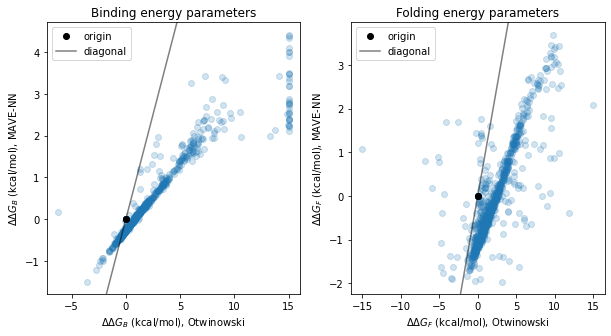

In [10]:
# Set plotting routine
def draw(ax, x, y, ddG_var, title):
    ax.scatter(x, y, alpha=.2)
    xlim = ax.get_xlim()
    ax.autoscale(False)
    ax.plot(0,0,'ok', label='origin')
    ax.plot(xlim, xlim, '-k', alpha=.5, label='diagonal')
    ax.set_xlabel(f'{ddG_var} (kcal/mol), Otwinowski')
    ax.set_ylabel(f'{ddG_var} (kcal/mol), MAVE-NN')
    ax.set_title(title)
    ax.legend()

# Create figure and make plots
fig, axs = plt.subplots(1,2, figsize=(10,5))
draw(ax=axs[0],
     x=ddG_b_mat_otwinowski.ravel(),
     y=ddG_b_mat_mavenn.ravel(),
     ddG_var='$\Delta \Delta G_B$',
     title='Binding energy parameters')
draw(ax=axs[1],
     x=ddG_f_mat_otwinowski.ravel(),
     y=ddG_f_mat_mavenn.ravel(),
     ddG_var='$\Delta \Delta G_F$',
     title='Folding energy parameters')


Finally, we compare our thermodynamic model's folding energy predictions to the $\Delta \Delta G_F$ measurements of Nisthal et al. (2019).

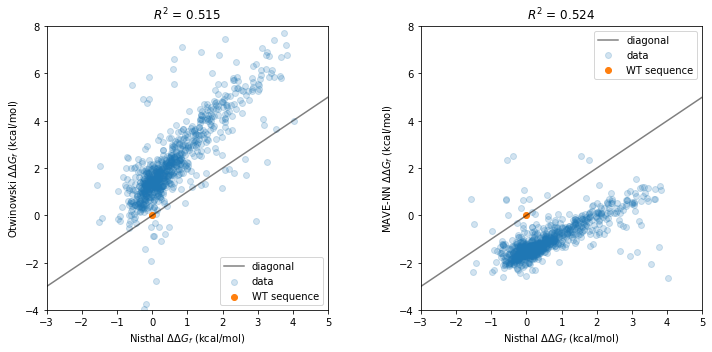

In [11]:
# Load Nisthal data
nisthal_df = mavenn.load_example_dataset('nisthal')
nisthal_df.set_index('x', inplace=True)

# Get Nisthal folding energies relative to WT
dG_f_nisthal = nisthal_df['y']
dG_f_wt_nisthal = dG_f_nisthal[wt_seq]
ddG_f_nisthal = dG_f_nisthal - dG_f_wt_nisthal

# Get MAVE-NN folding energies relative to WT
x_nisthal = nisthal_df.index.values
x_nisthal_ohe = mavenn.src.utils.x_to_ohe(x=x_nisthal,
                                          alphabet=model.alphabet)
ddG_f_vec = ddG_f_mat_mavenn.ravel().reshape([1,-1])
ddG_f_mavenn = np.sum(ddG_f_vec*x_nisthal_ohe, axis=1)

# Get Otwinowski folding energies relative to WT
ddG_f_vec_otwinowski = ddG_f_mat_otwinowski.ravel().reshape([1,-1])
ddG_f_otwinowski = np.sum(ddG_f_vec_otwinowski*x_nisthal_ohe, axis=1)

# Define plotting routine
def draw(ax, y, model_name):
    Rsq = np.corrcoef(ddG_f_nisthal, y)[0, 1]**2
    ax.scatter(ddG_f_nisthal, y, alpha=.2, label='data')
    ax.scatter(0,0, label='WT sequence')
    xlim = [-3,5]
    ax.set_xlim(xlim)
    ax.set_ylim([-4,8])
    ax.plot(xlim, xlim, color='k', alpha=.5, label='diagonal')
    ax.set_xlabel('Nisthal $\Delta \Delta G_f$ (kcal/mol)')
    ax.set_ylabel(f'{model_name} $\Delta \Delta G_f$ (kcal/mol)')
    ax.set_title(f'$R^2$ = {Rsq:.3f}')
    ax.legend()

# Make figure
fig, axs = plt.subplots(1,2,figsize=[10,5])
draw(ax=axs[0],
     y=ddG_f_otwinowski,
     model_name='Otwinowski')
draw(ax=axs[1],
     y=ddG_f_mavenn,
     model_name='MAVE-NN')

fig.tight_layout(w_pad=5)

## References

1. Otwinowski, J. Biophysical Inference of Epistasis and the Effects of Mutations on Protein Stability and Function. Mol Biol Evol 35, 2345–2354 (2018).

2. Olson, C. A., Wu, N. C., Sun, R. A comprehensive biophysical description of pairwise epistasis throughout an entire protein domain. Curr Biol 24, 2643–2651 (2014).

3. Tareen, A., Posfai, A., Ireland, W. T., McCandlish, D. M. & Kinney, J. B. MAVE-NN: learning genotype-phenotype maps from multiplex assays of variant effect. bioRxiv doi:10.1101/2020.07.14.201475 (2020).

4. Nisthal, A., Wang, C. Y., Ary, M. L., Mayo, S. L. Protein stability engineering insights revealed by domain-wide comprehensive mutagenesis. Proc Natl Acad Sci 116, 16367–16377 (2019).